In [11]:
import os
print(os.getcwd())

import torch
from torch import distributions as D
import matplotlib.pyplot as plt
from utils.ScaledBeta import ScaledBeta

from utils.ParticleCloud import ParticleCloud
from utils.Prior import IndependentPrior, KdePrior

from models.Bs import Bs
from models.Cev import Cev

/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis


# BS

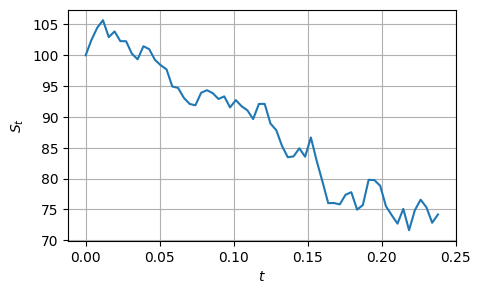

In [2]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
model = Bs(dt=dt)
T = 30 / 252

S0 = torch.tensor(100.0)
params = torch.tensor([[0.1, 0.2]])
S1 = model.simulate(params, S0, T, M=1)
t1 = len(S1)

params = torch.tensor([[-0.1, 0.5]])
S2 = model.simulate(params, S1[-1], T, M=1)

S = torch.concatenate([S1[:, 0], S2[:, 0]])

plt.figure(figsize=(5,3))
plt.plot(torch.linspace(0, 2 * T, len(S)), S.detach())
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

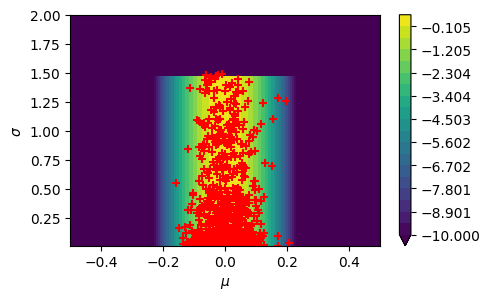

In [4]:
torch.manual_seed(0)
#pi_0 = Prior(dists = [Uniform(-1.0, 1.0), Uniform(1e-4, 1.0)])
pi_0 = IndependentPrior(dists=[
    D.Normal(loc=torch.tensor(0.0), scale=torch.tensor(0.05)),
    D.Uniform(low=torch.tensor(0.01).log(), high=torch.tensor(1.5).log())
    #D.Normal(loc=torch.log(torch.tensor(0.5)), scale=torch.tensor(0.3))
])
n_particles = 1000

pc = ParticleCloud(model, pi_0, n_particles, bandwidth='scott')
fig = pc.plot_bs(background='prior', scale='natural')

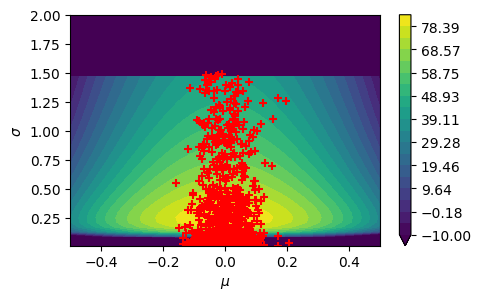

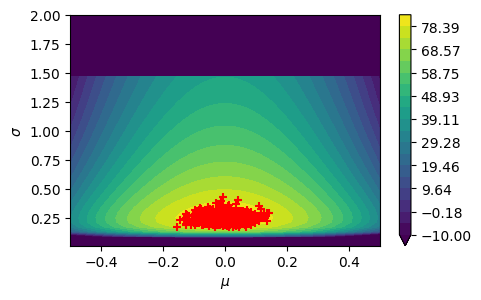

In [5]:
data1 = S[:t1]
fig = pc.plot_bs(background='posterior', scale='natural', new_data=data1)

pc.update_sgld(data1, n_steps = 1000, lr_1 = 0.001, lr_2 = 0.0001, gamma = 0.51)
#pc.update_gd(data1, n_steps = 1000, lr = 0.0001)
fig = pc.plot_bs(background='posterior', scale='natural', new_data=data1)

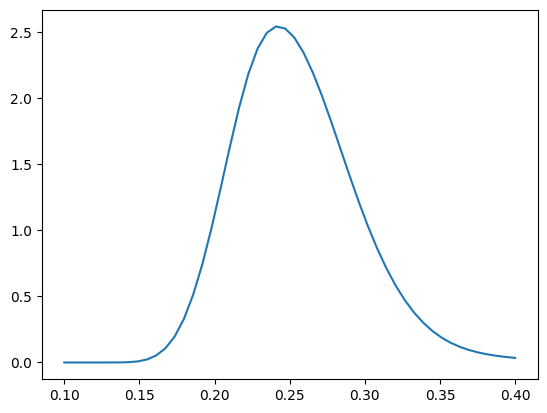

In [6]:
particles = pc.get_particles().clone()

kde = KdePrior(particles, bandwidth='scott')

x = torch.linspace(-0.5, 0.5, 51)
y = torch.log(torch.linspace(0.1, 0.4, 50))
X, Y = torch.meshgrid(x, y, indexing='ij')
grid = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
density = torch.exp(kde.log_prob(grid)).reshape(51, 50)

marginal = torch.trapezoid(density, x=x, dim=0)
marginal_natural = marginal / torch.exp(y)

plt.plot(torch.exp(y), marginal)

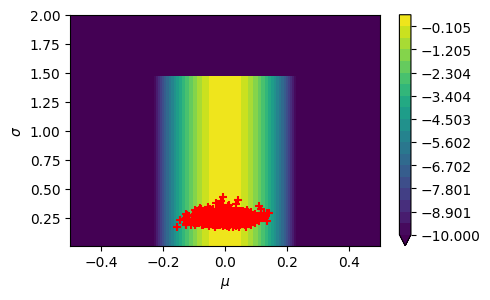

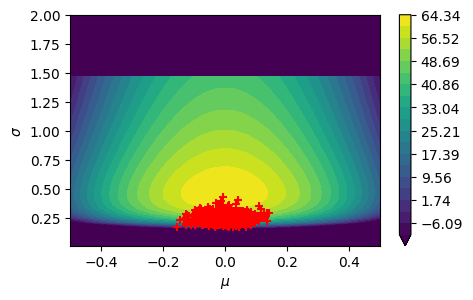

In [7]:
pc.update_prior(method='initial')
fig = pc.plot_bs(background='prior', scale='natural')

data2 = S[t1:]
fig = pc.plot_bs(background='posterior', scale='natural', new_data=data2)

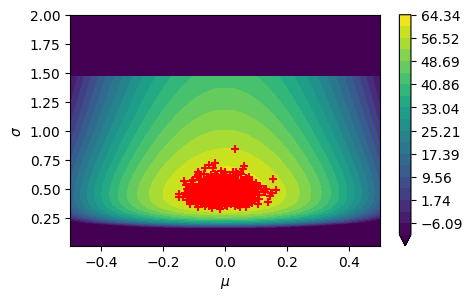

In [8]:
pc.update_sgld(data2, n_steps = 1000, lr_1 = 0.001, lr_2 = 0.0001, gamma = 0.51)
fig = pc.plot_bs(background='posterior', scale='natural', new_data=data2)

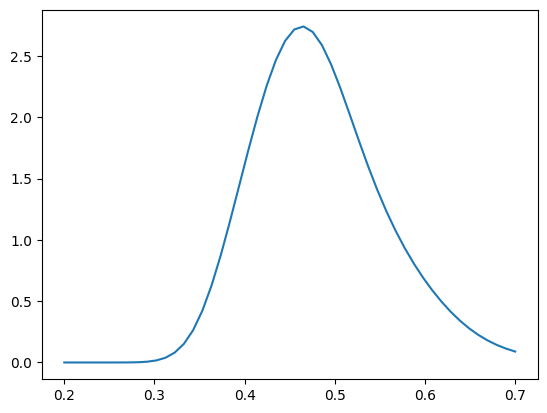

In [9]:
particles = pc.get_particles().clone()

kde = KdePrior(particles, bandwidth='scott')

x = torch.linspace(-0.5, 0.5, 51)
y = torch.log(torch.linspace(0.2, 0.7, 50))
X, Y = torch.meshgrid(x, y, indexing='ij')
grid = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
density = torch.exp(kde.log_prob(grid)).reshape(51, 50)

marginal = torch.trapezoid(density, x=x, dim=0)
marginal_natural = marginal / torch.exp(y)

plt.plot(torch.exp(y), marginal)

# CEV

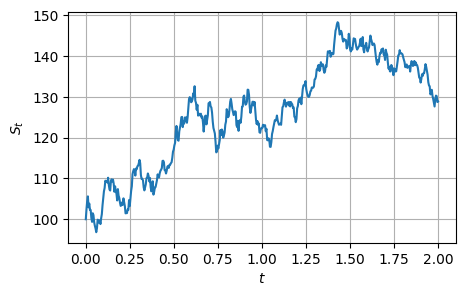

In [10]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
cev_model = Cev(dt=dt)
T = 1.0

S0 = torch.tensor(100.0)
params = torch.tensor([[0.1, 2.0, 1.0]])
S1 = cev_model.simulate(params, S0, T, M=1)
t1 = len(S1)

params = torch.tensor([[-0.1, 5.0, 0.5]])
S2 = cev_model.simulate(params, S1[-1], T, M=1)

S = torch.concatenate([S1[:, 0], S2[:, 0]])

plt.figure(figsize=(5,3))
plt.plot(torch.linspace(0, 2 * T, len(S)), S.detach())
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

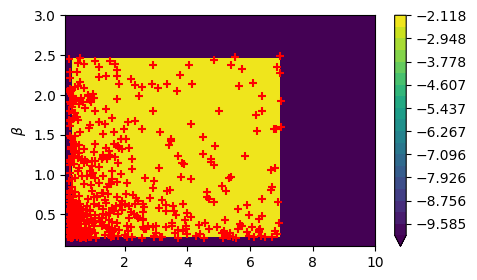

In [13]:
torch.manual_seed(0)

pi_0 = IndependentPrior(dists=[
    D.Normal(
        loc=torch.tensor(0.0),
        scale=torch.tensor(0.05)
    ),
    D.Normal(
        loc=torch.tensor(0.0),
        scale=torch.tensor(1.0)
    ),
    D.Normal(
        loc=torch.tensor(0.0),
        scale=torch.tensor(0.3)
    ),
])
pi_0 = IndependentPrior(dists=[
    D.Normal(
        loc=torch.tensor(0.0),
        scale=torch.tensor(0.05)
    ),
    ScaledBeta(
        alpha=torch.tensor(1.01),
        beta=torch.tensor(1.01),
        low=torch.tensor(0.2).log(),
        high=torch.tensor(7.0).log()
    ),
    ScaledBeta(
        alpha=torch.tensor(1.01),
        beta=torch.tensor(1.01),
        low=torch.tensor(0.2).log(),
        high=torch.tensor(2.5).log()
    ),
])
pi_0 = IndependentPrior(dists=[
    D.Normal(
        loc=torch.tensor(0.0),
        scale=torch.tensor(0.05)
    ),
    D.Uniform(
        low=torch.tensor(0.2).log(),
        high=torch.tensor(7.0).log()
    ),
    D.Uniform(
        low=torch.tensor(0.2).log(),
        high=torch.tensor(2.5).log()
    ),
])
n_particles = 500

cev_pc = ParticleCloud(cev_model, pi_0, n_particles, bandwidth='scott')
fig = cev_pc.plot_cev(background='prior', scale='natural', mu=torch.tensor(0.1))

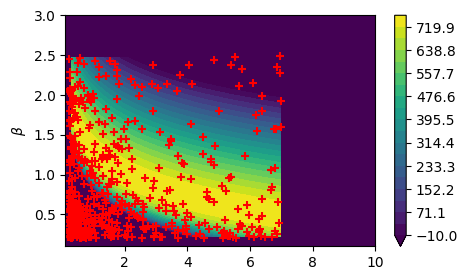

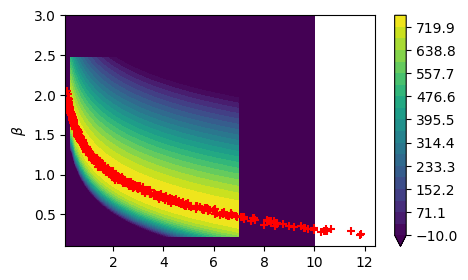

In [14]:
data1 = S[:t1]
fig = cev_pc.plot_cev(background='posterior', scale='natural', new_data=data1, mu=torch.tensor(0.1))

cev_pc.update_sgld(data1, n_steps = 1000, lr_1 = 0.0001, lr_2 = 0.00001, gamma = 0.51)
#cev_pc.update_gd(data1, n_steps = 1000, lr = 0.0001)
fig = cev_pc.plot_cev(background='posterior', scale='natural', new_data=data1, mu=torch.tensor(0.1))

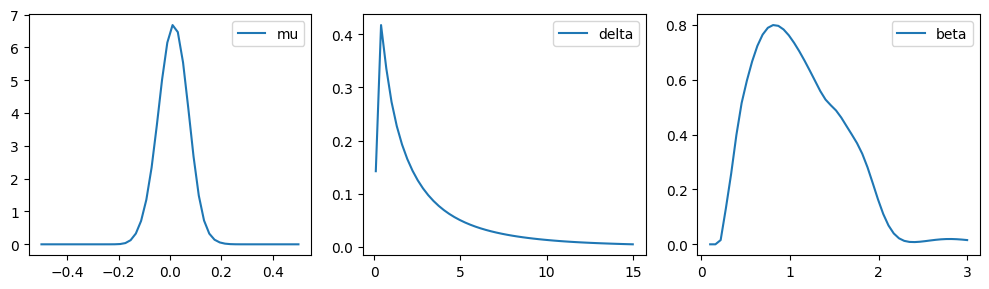

In [15]:
particles = cev_pc.get_particles().clone()

kde = KdePrior(particles, bandwidth='scott')

x = torch.linspace(-0.5, 0.5, 50)
y = torch.log(torch.linspace(0.1, 15, 50))
z = torch.log(torch.linspace(0.1, 3.0, 50))
X, Y, Z = torch.meshgrid([x, y, z], indexing='ij')
grid = torch.stack([X.reshape(-1), Y.reshape(-1), Z.reshape(-1)], dim=1)

density = torch.exp(kde.log_prob(grid)).reshape(50, 50, 50)
marginal_x = torch.trapezoid(density, x=x, dim=0)
marginal_xy = torch.trapezoid(marginal_x, x=y, dim=0)
marginal_xz = torch.trapezoid(marginal_x, x=z, dim=1)
marginal_y = torch.trapezoid(density, x=y, dim=1)
marginal_yz = torch.trapezoid(marginal_y, x=z, dim=1)

marginal_beta = marginal_xy / torch.exp(z)
marginal_delta = marginal_xz / torch.exp(y)
marginal_mu = marginal_yz

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
axs[0].plot(x, marginal_mu, label='mu')
axs[1].plot(torch.exp(y), marginal_delta, label='delta')
axs[2].plot(torch.exp(z), marginal_beta, label='beta')

for i in range(3):
    axs[i].legend()
plt.tight_layout()